In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
import pandas as pd
import numpy as np
from forestry_carbon_arr.core import ForestryCarbonARR
import os

import gcsfs

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

# ---------- CONFIG ----------
gcs_folder = "remote_sensing_saas/01-korindo/mpc_monthly"  # without gs://
asset_folder = "projects/remote-sensing-476412/assets/korindo_sentinel2_monthly_mpc"
local_dir = "/mnt/data/s2_monthly"                     # your folder containing many *.tif
# ----------------------------------------

# forestry.config

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
from forestry_carbon_arr.utils.zarr_utils import load_dataset_zarr

zarr_path = forestry.config['mpc_zarr_path']
# zarr_path = 'data/ds_resampled.zarr'
# storage = 'local'
storage = 'gcs'

## dataset check
ds_sentinel_to_gee = load_dataset_zarr(zarr_path, storage=storage)
ds_sentinel_to_gee

# ## check the variables
# ds_sentinel_to_gee.data_vars



📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee.zarr
✅ Dataset loaded: {'time': 71, 'y': 3213, 'x': 4489}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 108GB
Dimensions:    (time: 71, y: 3213, x: 4489)
Coordinates:
    epsg       int64 8B ...
    id         (time) <U54 15kB dask.array<chunksize=(10,), meta=np.ndarray>
    platform   (time) <U11 3kB dask.array<chunksize=(10,), meta=np.ndarray>
    proj:code  <U10 40B ...
  * time       (time) datetime64[ns] 568B 2015-11-26T02:40:32.031000 ... 2017...
  * x          (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y          (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
Data variables: (12/14)
    blue       (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    coastal    (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    green      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    is_valid   (time, y, x) bool 1GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    nir        (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    nir2       (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    ...         ...
    redE2      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    redE3      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    redE4      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    scl        (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    swir1      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
    swir2      (time, y, x) float64 8GB dask.array<chunksize=(10, 512, 512), meta=np.ndarray>
Attributes:
    crs:         epsg:32749
    resolution:  10

In [4]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

zarr_path = forestry.config['mpc_zarr_path'].replace('_gee.zarr', '_gee_monthly.zarr')

use_zarr_monthly = True
if use_zarr_monthly != True:
    print('use_STAC')
    valid_pixel_threshold = forestry.config['valid_pixel_threshold']

    # Filter scenes with sufficient valid pixels
    valid = ds_sentinel_to_gee['is_valid'].sum(dim=['x', 'y'])
    total = len(ds_sentinel_to_gee.x) * len(ds_sentinel_to_gee.y)
    valid_pixels = ((valid / total) * 100).round()

    print(f"Valid pixel percentages: min={valid_pixels.min().values:.1f}%, max={valid_pixels.max().values:.1f}%")
    print(f"Scenes with >{valid_pixel_threshold}% valid pixels: {(valid_pixels > valid_pixel_threshold).sum().values}/{len(valid_pixels)}")

    # Keep only scenes with sufficient valid pixels
    ds = ds_sentinel_to_gee.sel(time=valid_pixels > valid_pixel_threshold, drop=True)
    print(f"After valid pixel filtering: {ds.dims}")

    # Apply cloud masking
    ds = ds.where(ds.is_valid)
    print("Applied cloud masking")

    print("🔍 VERIFYING DATASET STATE:")
    print("=" * 50)
    print(f"📊 Dataset dimensions: {ds.dims}")
    print(f"📋 Available variables: {list(ds.data_vars.keys())}")
    print(f"📅 Time range: {ds.time.min().values} to {ds.time.max().values}")

    # Monthly Composite Mosaic (similar to GEE)
    # This creates monthly median composites, similar to GEE's monthly mosaicking

    print("📅 Creating monthly median composites...")
    print(f"   Input: {ds.dims['time']} scenes")
    print(f"   Method: Median aggregation per month (like GEE)")

    # Select only data variables (exclude metadata like 'is_valid', 'scl')
    data_vars = [var for var in ds.data_vars if var not in ['is_valid', 'scl']]
    ds_data = ds[data_vars]

    # Create monthly median composites using resample
    # 'MS' = Month Start (groups by calendar month)
    # This is equivalent to GEE's group by year-month and reduce with median
    ds_monthly = ds_data.resample(time='MS').median(dim='time')

    # Rename variables to add '_median' suffix (like GEE does)
    # This matches the GEE convention where monthly composites have _median suffix
    rename_dict = {var: f"{var}_median" for var in ds_monthly.data_vars}
    ds_monthly = ds_monthly.rename(rename_dict)

    print(f"   Output: {ds_monthly.dims['time']} monthly composites")
    print(f"   Variables: {list(ds_monthly.data_vars)}")
    print(f"   Time range: {ds_monthly.time.min().values} to {ds_monthly.time.max().values}")

    # Verify the result
    print("\n✅ Monthly composites created!")
    print(f"📊 Dataset dimensions: {dict(ds_monthly.sizes)}")
    print(f"📋 Variables with '_median' suffix: {list(ds_monthly.data_vars)}")

    import pandas as pd

    # Set time to 15th of each month
    ds_monthly = ds_monthly.assign_coords(
        time=pd.to_datetime([d.replace(day=15) for d in pd.to_datetime(ds_monthly.time.values)])
    )

    print(f"✅ Time coordinates set to 15th of each month")

    # Create id coordinate
    id_values = [f'Sentinel2_{d.year}_{d.month:02d}' for d in pd.to_datetime(ds_monthly.time.values)]
    ds_monthly = ds_monthly.assign_coords(id=('time', id_values))

    # Verify it's auxiliary (not a dimension)
    assert 'id' not in ds_monthly.dims, "'id' should not be a dimension"
    assert 'id' in ds_monthly.coords, "'id' should be a coordinate"
    assert ds_monthly.coords['id'].dims == ('time',), "'id' should be associated with 'time' dimension"

    print(f"✅ 'id' is an auxiliary coordinate associated with 'time'")
    print(f"   Sample IDs: {ds_monthly.coords['id'].values[:3]}")

    # ds_monthly

    # Add metadata similar to GEE
    import pandas as pd

    # Extract year and month from time coordinates
    time_pd = pd.to_datetime(ds_monthly.time.values)
    ds_monthly = ds_monthly.assign_coords({
        'year': ('time', time_pd.year),
        'month': ('time', time_pd.month)
    })

    # Count original scenes per month (optional)
    # This would require keeping track of original scene counts
    # For now, the monthly composite is the main output

    print(f"✅ Monthly composites with metadata created!")

    save_dataset_efficient_zarr(
        ds_monthly, forestry.config['mpc_zarr_path'].replace('_gee.zarr', '_gee_monthly.zarr'),
        compression='zstd',  # GEE supports zstd
        gee_compatible=True  # Still enforces Zarr v2
    )

else:
    ds_monthly = load_dataset_zarr(zarr_path, storage='gcs')

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr
✅ Dataset loaded: {'time': 25, 'y': 3213, 'x': 4489}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [5]:
ds_monthly
        

<xarray.Dataset> Size: 35GB
Dimensions:         (time: 25, y: 3213, x: 4489)
Coordinates:
    epsg            int64 8B ...
    id              (time) <U17 2kB dask.array<chunksize=(20,), meta=np.ndarray>
    month           (time) int32 100B dask.array<chunksize=(20,), meta=np.ndarray>
    proj:code       <U10 40B ...
  * time            (time) datetime64[ns] 200B 2015-11-15 ... 2017-11-15
  * x               (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y               (y) float64 26kB 9.982e+06 9.982e+06 ... 9.949e+06 9.949e+06
    year            (time) int32 100B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    blue_median     (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    coastal_median  (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    green_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    nir2_median     (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    nir_median      (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    red_median      (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    redE1_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    redE2_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    redE3_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    redE4_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    swir1_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
    swir2_median    (time, y, x) float64 3GB dask.array<chunksize=(20, 256, 256), meta=np.ndarray>
Attributes:
    crs:         epsg:32749
    resolution:  10

In [6]:
'''
Explanation:
1. resample(time='MS').median(dim='time'):
- 'MS' = Month Start (groups by calendar month)
- Groups all scenes within each month
- Computes median across time for each month
- Equivalent to GEE's month_collection.reduce(ee.Reducer.median())
2. Rename with _median suffix:
- Matches GEE's convention where monthly composites have _median suffix
- Example: blue → blue_median, NDVI → NDVI_median
3. Result:
- One composite per month (if data exists for that month)
- Each variable has _median suffix
- Time dimension represents monthly timestamps (1st of each month)
'''

"\nExplanation:\n1. resample(time='MS').median(dim='time'):\n- 'MS' = Month Start (groups by calendar month)\n- Groups all scenes within each month\n- Computes median across time for each month\n- Equivalent to GEE's month_collection.reduce(ee.Reducer.median())\n2. Rename with _median suffix:\n- Matches GEE's convention where monthly composites have _median suffix\n- Example: blue → blue_median, NDVI → NDVI_median\n3. Result:\n- One composite per month (if data exists for that month)\n- Each variable has _median suffix\n- Time dimension represents monthly timestamps (1st of each month)\n"

In [7]:
list_bands = list(ds_monthly.data_vars.keys())
list_bands

['blue_median',
 'coastal_median',
 'green_median',
 'nir2_median',
 'nir_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'redE4_median',
 'swir1_median',
 'swir2_median']

In [8]:
monthly_path = forestry.config['mpc_zarr_path'].replace('_gee.zarr', '_gee_monthly.zarr')

list_path_gee_band_gcs = [os.path.join(monthly_path, f,'.zarray') for f in list_bands]

# list_path_gee_band_gcs

In [9]:
#Displaying the vectors
from forestry_carbon_arr.core.utils import DataUtils
from wfs_manager import WFSManager

# result
data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

wfs = WFSManager(fastapi_url="http://fastapi:8000", wfs_base_url="http://localhost:8001")
wfs.addLayer(aoi_ee, "AOI Boundary")
wfs.publish()

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


{'status': 'success',
 'total_layers': 1,
 'successful_layers': 1,
 'failed_layers': 0,
 'layers': {'aoi_boundary': {'status': 'success',
   'layer_name': 'aoi_boundary',
   'fc_url': 'http://fastapi:8000/fc/aoi_boundary',
   'wfs_url': 'http://localhost:8001/wfs?service=WFS&version=1.1.0&request=GetFeature&typename=aoi_boundary',
   'feature_count': 1,
   'response': {'message': "FeatureCollection 'aoi_boundary' created successfully",
    'name': 'aoi_boundary',
    'type': 'FeatureCollection',
    'count': 1}}},
 'service_urls': {'wfs_capabilities': 'http://localhost:8001/wfs?service=WFS&version=1.1.0&request=GetCapabilities',
  'wfs_base': 'http://localhost:8001/wfs'}}

In [10]:
import xarray as xr
import rasterio
from rasterio.transform import from_origin
import numpy as np
import pandas as pd
import os

use_exported_gee = True 

if use_exported_gee != True:
    # -------------------------------
    # User inputs
    # -------------------------------
    zarr_path = zarr_path                            # your existing multi-band Zarr
    output_dir = "/mnt/data/s2_monthly/"             # where GeoTIFFs will be written locally
    bands = list_bands                                # your 12 band names
    crs = "EPSG:32749"                                # your projection
    pixel_size = forestry.config['resolution_satellite']  # 10m
    # -------------------------------

    # Create folder if missing
    os.makedirs(output_dir, exist_ok=True)

    # Open Zarr
    print("📂 Opening Zarr dataset...")
    ds = xr.open_zarr(zarr_path, consolidated=True)

    # Check dimensions
    print("Dimensions:", ds.dims)
    print("Variables:", list(ds.data_vars))

    # Assume data is stored as ds[band][time, y, x]
    # And coordinate mappings:
    # ds['x'], ds['y'] correspond to pixel centers

    # Compute transform
    # Assuming regular grid: need origin from max y, min x
    x0 = float(ds['x'][0])
    y0 = float(ds['y'][0])

    # You must adjust origin depending on your coordinate ordering:
    # If coordinates go from top (max y) downward, use ds['y'][0]
    # If reversed, use ds['y'][-1]
    if ds['y'][1] < ds['y'][0]:
        # y decreasing
        transform = from_origin(x0, y0, pixel_size, pixel_size)
    else:
        # y increasing
        y0 = float(ds['y'][-1])
        transform = from_origin(x0, y0, pixel_size, pixel_size)

    times = ds['time'].values
    ids = ds['id'].values

    print(f"🕒 Found {len(times)} timesteps")

    # Loop through each timestep
    for i in range(len(times)):
        print(f"\n🟦 Exporting timestep {i+1}/{len(times)} ...")

        timestamp = pd.to_datetime(times[i])
        img_id = ids[i]

        # Gather band arrays in order
        band_arrays = []
        for b in bands:
            arr = ds[b][i].values  # (y,x)
            band_arrays.append(arr)

        band_arrays = np.stack(band_arrays, axis=0)   # (band, y, x)

        # Output file name
        out_path = os.path.join(output_dir, f"{img_id}.tif")

        # Write GeoTIFF
        with rasterio.open(
            out_path,
            "w",
            driver="GTiff",
            height=band_arrays.shape[1],
            width=band_arrays.shape[2],
            count=band_arrays.shape[0],
            dtype=band_arrays.dtype,
            crs=crs,
            transform=transform,
            compress="LZW"
        ) as dst:
            for bi in range(band_arrays.shape[0]):
                dst.write(band_arrays[bi], bi + 1)
                dst.set_band_description(bi + 1, bands[bi])

        print(f"   ✔ Saved: {out_path}")

    print("\n🎉 All GeoTIFFs saved successfully.")
    print("Next steps:")
    print("1) Upload to GCS:")
    print("      gsutil -m cp /mnt/data/s2_monthly/*.tif gs://your-bucket/s2_tiffs/")
    print("2) Import to EE as assets:")
    print("      earthengine upload image --asset_id=projects/.../assetfolder/... gs://your-bucket/s2_tiffs/xxxx.tif")

    # !gsutil -m cp /mnt/data/s2_monthly/*.tif gs://remote_sensing_saas/01-korindo/mpc_monthly/
    import os
    import shutil

    # List all local TIFFs
    tif_files = [f for f in os.listdir(local_dir) if f.lower().endswith(".tif")]
    print(f"Found {len(tif_files)} TIFFs to upload.\n")

    for filename in tif_files:
        local_path = os.path.join(local_dir, filename)
        gcs_path = f"{gcs_folder}/{filename}"

        print(f"Uploading {filename} → gs://{gcs_path}")

        with open(local_path, 'rb') as local_f:
            with fs.open(gcs_path, 'wb') as gcs_f:
                shutil.copyfileobj(local_f, gcs_f)

    print("\n✔ All uploads completed.")
    print(f"Files now located at: gs://{gcs_folder}/")

else:
    print("use_exported_gee is True")


use_exported_gee is True


In [11]:
# import ee
# ee.Initialize()

# folder = "projects/remote-sensing-476412/assets/korindo_sentinel2_monthly_mpc"
# ee.data.createAsset({'type': 'FOLDER'}, folder)
# print("Folder created:", folder)


In [12]:
import ee
import gcsfs
import time

if use_exported_gee != True:
    # List all .tif files
    tiffs = sorted([f for f in fs.ls(gcs_folder) if f.lower().endswith(".tif")])
    print("Found", len(tiffs), "GeoTIFFs")

    for tif_path in tiffs:
        filename = tif_path.split("/")[-1]
        asset_id = f"{asset_folder}/{filename.replace('.tif','')}"

        print(f"INGEST → {filename}")
        print(f"   GCS:    gs://{tif_path}")
        print(f"   ASSET:  {asset_id}")

        request_id = ee.data.newTaskId()[0]

        # ✔ Correct schema (2025)
        ingestion_params = {
            "id": asset_id,
            "tilesets": [{
                "sources": [{
                    "uris": [f"gs://{tif_path}"]
                }]
            }]
        }

        ee.data.startIngestion(request_id, ingestion_params)
        print(f"   Task started: {request_id}\n")

        time.sleep(0.3)

    print("\n✔ All ingestion tasks submitted!")
    print("Monitor: https://code.earthengine.google.com/tasks")

print("use_exported_gee is True")
print(f"asset is already in GEE: {asset_folder}")


use_exported_gee is True
asset is already in GEE: projects/remote-sensing-476412/assets/korindo_sentinel2_monthly_mpc


In [13]:
# ds_monthly
list_bands


['blue_median',
 'coastal_median',
 'green_median',
 'nir2_median',
 'nir_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'redE4_median',
 'swir1_median',
 'swir2_median']

In [14]:
## AFTER INGESTION
### TRY the new Approach, wmts manager, make the simpler line for adding layer based on project
from wmts_manager import WMTSManager

col = ee.ImageCollection(asset_folder)

col_rename = col.map(lambda img: img.select(['b1', 'b2', 'b3', 'b4', 'b5', 
                                             'b6', 'b7', 'b8', 'b9', 'b10', 
                                             'b11', 'b12']).rename(list_bands))

project_name = forestry.config['project_name']
image_mosaick = col_rename.first()
# vis_param = result['visualization_params']['mosaic']
vis_param = {'bands': ['swir2_median', 'nir_median', 'red_median'],
   'min': 0,
   'max': 6000,
   'gamma': 1.5}

mosaic_name = 'test_exported_asset_gee_geotiff_col'

wmts = WMTSManager(project_name=project_name, aoi=aoi_ee.geometry()) # equal to the defining map properties 
wmts.addLayer(image_mosaick, vis_param, mosaic_name)
wmts.publish() # execution to the WMTS server

INFO:wmts_manager:WMTSManager initialized for project: korindo
INFO:wmts_manager:Added layer: test_exported_asset_gee_geotiff_col
INFO:wmts_manager:Generating map IDs for 1 layers...


Generating GEE Map IDs...


INFO:wmts_manager:AOI processed: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
INFO:wmts_manager:Publishing 1 layers to WMTS...
INFO:gee_integration:GEE Integration Manager initialized:
INFO:gee_integration:  FastAPI URL: http://fastapi:8000


✅ Centroid calculated successfully with error margin 1
Calculated bbox from coordinates: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
✅ AOI processed successfully:
   - Center: [111.90816469614359, -0.3125187262245936]
   - Area: Unknown
   - BBox: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}


INFO:gee_integration:  MapStore Config: /usr/src/app/mapstore/configs/localConfig.json
INFO:gee_integration:Processing GEE analysis: korindo
INFO:gee_integration:🧹 Clearing duplicate projects before processing new analysis...
INFO:cache_manager:No existing catalog entries to check for duplicates
INFO:gee_integration:✅ Duplicate clearing successful: 0 duplicates cleared, 0 unique projects kept
INFO:gee_integration:✅ Cache cleared: 0 duplicate entries, kept 0 unique projects
INFO:gee_integration:Using complex layer info for 'test_exported_asset_gee_geotiff_col': ['tile_url', 'name', 'description', 'vis_params']
INFO:gee_integration:Registering with FastAPI: korindo_20251115_084904
INFO:gee_integration:✅ FastAPI registration successful: MapStore catalog updated successfully
INFO:gee_integration:Creating FastAPI proxy URLs for project: korindo_20251115_084904
INFO:gee_integration:✅ Created 1 FastAPI proxy URLs
INFO:gee_integration:Updating MapStore WMTS: korindo_20251115_084904
INFO:gee_in

{'status': 'success',
 'project_id': 'korindo_20251115_084904',
 'project_name': 'korindo',
 'fastapi_registration': {'status': 'success',
  'message': 'MapStore catalog updated successfully',
  'layers_count': 1},
 'proxy_urls_creation': {'status': 'success',
  'message': 'Created 1 proxy URLs',
  'proxy_urls': {'test_exported_asset_gee_geotiff_col': {'proxy_url': 'http://fastapi:8000/tiles/korindo_20251115_084904/test_exported_asset_gee_geotiff_col/{z}/{x}/{y}',
    'original_url': 'https://earthengine.googleapis.com/v1/projects/remote-sensing-476412/maps/3d5de8c355c90f6a5a13fca0785e7405-f19eb80fb75272ba86f85350284e36a1/tiles/{z}/{x}/{y}',
    'layer_name': 'test_exported_asset_gee_geotiff_col',
    'description': 'TEST_EXPORTED_ASSET_GEE_GEOTIFF_COL visualization from GEE analysis'}},
  'layers_count': 1},
 'wmts_configuration': {'status': 'success',
  'message': 'WMTS configuration updated successfully',
  'service_id': 'GEE_analysis_WMTS_layers',
  'layers_available': ['korindo_20

In [15]:
col_rename_scaled = col_rename.map(lambda img: img.divide(10000))
image_mosaick_scaled = col_rename_scaled.first()

vis_param = {'bands': ['swir2_median', 'nir_median', 'red_median'],
   'min': 0,
   'max': 0.6,
   'gamma': 1.5}

wmts = WMTSManager(project_name=project_name, aoi=aoi_ee.geometry()) # equal to the defining map properties 
wmts.addLayer(image_mosaick_scaled, vis_param, 'test_gee_divided_10000')
wmts.publish() # execution to the WMTS server

INFO:wmts_manager:WMTSManager initialized for project: korindo
INFO:wmts_manager:Added layer: test_gee_divided_10000
INFO:wmts_manager:Generating map IDs for 1 layers...


Generating GEE Map IDs...


INFO:wmts_manager:AOI processed: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
INFO:wmts_manager:Publishing 1 layers to WMTS...
INFO:gee_integration:GEE Integration Manager initialized:
INFO:gee_integration:  FastAPI URL: http://fastapi:8000
INFO:gee_integration:  MapStore Config: /usr/src/app/mapstore/configs/localConfig.json
INFO:gee_integration:Processing GEE analysis: korindo
INFO:gee_integration:🧹 Clearing duplicate projects before processing new analysis...
INFO:cache_manager:No existing catalog entries to check for duplicates
INFO:gee_integration:✅ Duplicate clearing successful: 0 duplicates cleared, 0 unique projects kept
INFO:gee_integration:✅ Cache cleared: 0 duplicate entries, kept 0 unique projects
INFO:gee_integration:Using complex layer info for 'test_gee_divided_10000': ['tile_url', 'name', 'description', 'vis_params']
INFO:gee_integration:Registering with FastAPI: korindo_20251115_084904
INFO:gee_integration

✅ Centroid calculated successfully with error margin 1
Calculated bbox from coordinates: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}
✅ AOI processed successfully:
   - Center: [111.90816469614359, -0.3125187262245936]
   - Area: Unknown
   - BBox: {'minx': 111.706493374869, 'miny': -0.457839253478653, 'maxx': 112.109836017418, 'maxy': -0.167195667545911}


INFO:gee_utils:Successfully updated MapStore WMTS service: gee_analysis_wmts
INFO:gee_utils:Getting current WMTS layers...
INFO:gee_utils:Comprehensive WMTS refresh completed successfully - Found 1 layers
INFO:gee_integration:✅ MapStore WMTS configuration updated
INFO:gee_integration:   New layers found: 1
INFO:wmts_manager:WMTS publishing completed: success


{'status': 'success',
 'project_id': 'korindo_20251115_084904',
 'project_name': 'korindo',
 'fastapi_registration': {'status': 'success',
  'message': 'MapStore catalog updated successfully',
  'layers_count': 1},
 'proxy_urls_creation': {'status': 'success',
  'message': 'Created 1 proxy URLs',
  'proxy_urls': {'test_gee_divided_10000': {'proxy_url': 'http://fastapi:8000/tiles/korindo_20251115_084904/test_gee_divided_10000/{z}/{x}/{y}',
    'original_url': 'https://earthengine.googleapis.com/v1/projects/remote-sensing-476412/maps/d4640fdb5c2da11117201f06768143c5-5b84a02c4298a877493fdb6d2e829491/tiles/{z}/{x}/{y}',
    'layer_name': 'test_gee_divided_10000',
    'description': 'TEST_GEE_DIVIDED_10000 visualization from GEE analysis'}},
  'layers_count': 1},
 'wmts_configuration': {'status': 'success',
  'message': 'WMTS configuration updated successfully',
  'service_id': 'GEE_analysis_WMTS_layers',
  'layers_available': ['korindo_20251115_084904_test_gee_divided_10000'],
  'layers_co

In [16]:
# STEP 1: Load AOI and initialize
print("=" * 60)
print("STEP 1: Load AOI and initialize")
print("=" * 60)

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd)} features")
print(f"   Area: {aoi_gpd.geometry.area.sum()/10000:.2f} hectares")

INFO:forestry_carbon_arr.core.utils:GEE already initialized


STEP 1: Load AOI and initialize


INFO:forestry_carbon_arr.core.utils:GeoDataFrame loaded from ./00_input/aoi_korindo.shp
INFO:forestry_carbon_arr.core.utils:Bounding box: [111.70649337  -0.45783925 112.10983602  -0.16719567]
INFO:forestry_carbon_arr.core.utils:AOI converted to Earth Engine format


✅ AOI loaded: 1 features
   Area: 0.00 hectares


/tmp/ipykernel_2937/19930234.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"   Area: {aoi_gpd.geometry.area.sum()/10000:.2f} hectares")


In [17]:
col_rename_scaled.first().bandNames().getInfo()

['blue_median',
 'coastal_median',
 'green_median',
 'nir2_median',
 'nir_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'redE4_median',
 'swir1_median',
 'swir2_median']

In [18]:
from forestry_carbon_arr.utils.gee_processing import rename_composite_bands

aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm).geometry()
aoi_bounds_utm = aoi_ee_utm_geom.bounds(maxError=1)

# Rename bands: remove '_median' suffix and exclude 'cloudM_median'
collection_monthly = rename_composite_bands(
    col_rename_scaled,
    remove_suffix='_median',
    exclude_bands=['coastal_median','redE1_median','redE2_median','redE3_median','redE4_median']
)

print(f"✅ Monthly ImageCollection: {collection_monthly.size().getInfo()} images")
band_names_monthly = collection_monthly.first().bandNames().getInfo()
print(f"   Bands: {', '.join(band_names_monthly[:5])}{'...' if len(band_names_monthly) > 5 else ''}")

INFO:forestry_carbon_arr.utils.gee_processing:Renaming bands: removing '_median' suffix...
INFO:forestry_carbon_arr.utils.gee_processing:   Original bands: 12
INFO:forestry_carbon_arr.utils.gee_processing:   After filtering: 7
INFO:forestry_carbon_arr.utils.gee_processing:   Example: blue_median -> blue
INFO:forestry_carbon_arr.utils.gee_processing:✅ Bands renamed successfully


✅ Monthly ImageCollection: 25 images
   Bands: blue, green, nir2, nir, red...


In [19]:
# STEP 5: Add spectral indices and apply smoothing
print("\n" + "=" * 60)
print("STEP 5: Add spectral indices and apply smoothing")
print("=" * 60)

from forestry_carbon_arr.utils.gee_processing import process_collection_with_indices_and_smoothing

collection_with_sg = process_collection_with_indices_and_smoothing(
    collection=collection_monthly,
    config=forestry.config,
    aoi_ee=aoi_ee,
    spectral_bands=['NDVI', 'EVI'],
    smoothing_window=3,  # Small window for 1 year test
    smoothing_polyorder=2,
    add_fcd=False
)

print(f"✅ Final collection: {collection_with_sg.size().getInfo()} images")
band_names_sg = collection_with_sg.first().bandNames().getInfo()
print(f"   Bands: {band_names_sg}")


INFO:forestry_carbon_arr.utils.gee_processing:============================================================
INFO:forestry_carbon_arr.utils.gee_processing:Processing collection: indices + smoothing
INFO:forestry_carbon_arr.utils.gee_processing:============================================================
INFO:forestry_carbon_arr.utils.gee_processing:Step 1: Adding spectral indices...
INFO:forestry_carbon_arr.utils.gee_processing:✅ Spectral indices added
INFO:forestry_carbon_arr.utils.gee_processing:Step 2.5: Adding EVI using eemont...



STEP 5: Add spectral indices and apply smoothing


INFO:forestry_carbon_arr.utils.gee_processing:✅ EVI added using eemont
INFO:forestry_carbon_arr.utils.gee_processing:Step 3: Applying Savitzky-Golay smoothing...
INFO:forestry_carbon_arr.utils.gee_processing:   Window length: 3
INFO:forestry_carbon_arr.utils.gee_processing:   Polynomial order: 2
INFO:forestry_carbon_arr.utils.gee_processing:   Bands to filter: ['NDVI', 'EVI']
INFO:forestry_carbon_arr.utils.gee_processing:Applying Savitzky-Golay filtering...
INFO:forestry_carbon_arr.utils.gee_processing:   Window length: 3
INFO:forestry_carbon_arr.utils.gee_processing:   Polynomial order: 2
INFO:forestry_carbon_arr.utils.gee_processing:   Bands to filter: ['NDVI', 'EVI']
INFO:forestry_carbon_arr.utils.gee_processing:✅ Savitzky-Golay filtering complete!
INFO:forestry_carbon_arr.utils.gee_processing:✅ Smoothing complete


✅ Final collection: 25 images
   Bands: ['NDVI', 'EVI']


In [20]:
# STEP 6: Convert to xarray using xee
print("\n" + "=" * 60)
print("STEP 6: Convert to xarray using xee")
print("=" * 60)

import xarray as xr

utm_crs = forestry.config['output_crs']
pixel_scale = forestry.config['resolution_satellite']

# Convert AOI geometry to UTM for xee
aoi_gpd_utm = aoi_gpd.to_crs(utm_crs)
aoi_gpd_utm.set_crs(utm_crs, inplace=True)
aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm).geometry()

print(f"   CRS: {utm_crs}")
print(f"   Scale: {pixel_scale}m")
print("   Converting...")

ds = xr.open_dataset(
    collection_with_sg,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom
)

print(f"✅ Dataset created: {dict(ds.sizes)}")
print(f"   Data variables: {list(ds.data_vars)}")



STEP 6: Convert to xarray using xee
   CRS: EPSG:32749
   Scale: 10m
   Converting...


/opt/venv/lib/python3.12/site-packages/xee/ext.py:696: UserWarning: Unable to retrieve 'system:time_start' values from an ImageCollection due to: No 'system:time_start' values found in the 'ImageCollection'.
  warnings.warn(


✅ Dataset created: {'time': 25, 'X': 4489, 'Y': 3213}
   Data variables: ['NDVI', 'EVI']


In [21]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 25, X: 4489, Y: 3213)
Coordinates:
  * time     (time) int64 200B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * X        (X) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * Y        (Y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    NDVI     (time, X, Y) float32 1GB ...
    EVI      (time, X, Y) float32 1GB ...
Attributes:
    crs:      EPSG:32749

In [22]:
# STEP 7: Rename dimensions and save/load from zarr
print("\n" + "=" * 60)
print("STEP 7: Save to zarr and reload (to avoid GEE server errors)")
print("=" * 60)

from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr
import os

use_exported_ds = True

# Determine zarr path
zarr_path = os.getenv('GCS_ZARR_DIR', '')
if zarr_path:
    if not zarr_path.startswith('gs://'):
        zarr_path = f"gs://{zarr_path}/ds_resampled_mpc.zarr"
    else:
        zarr_path = f"{zarr_path}/ds_resampled_mpc.zarr"
    storage = 'gcs'
    print(f"   Saving to GCS: {zarr_path}")
else:
    zarr_path = os.path.join(os.getcwd(), 'data', 'ds_resampled_mpc.zarr')
    storage = 'local'
    print(f"   Saving to local: {zarr_path}")

if use_exported_ds != True:

    # Rename dimensions (X, Y -> x, y)
    ds_resampled = ds.rename({'X': 'x', 'Y': 'y'})

    # Save to zarr
    chunk_sizes = {'time': 40, 'x': 1024, 'y': 1024}
    print("   Saving dataset to zarr...")
    save_dataset_efficient_zarr(
        ds_resampled,
        zarr_path,
        chunk_sizes=chunk_sizes,
        compression='lz4',
        compression_level=1,
        overwrite=True,
        storage=storage
    )
    print(f"✅ Dataset saved to zarr")

    # Load from zarr to avoid GEE server-side errors
    print(f"\n   Loading from: {zarr_path}")
else:
    ds_resampled = load_dataset_zarr(zarr_path, storage=storage)

print(f"✅ Dataset loaded from zarr")
print(f"   Dataset: {dict(ds_resampled.sizes)}")
print(f"   Variables: {list(ds_resampled.data_vars)}")
print(f"\n✅ ds_resampled_mpc ready for tsfresh processing")


INFO:forestry_carbon_arr.utils.zarr_utils:Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_mpc.zarr



STEP 7: Save to zarr and reload (to avoid GEE server errors)
   Saving to GCS: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_mpc.zarr
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_mpc.zarr
✅ Dataset loaded: {'time': 25, 'x': 4489, 'y': 3213}
✅ Dataset loaded from zarr
   Dataset: {'time': 25, 'x': 4489, 'y': 3213}
   Variables: ['EVI', 'NDVI']

✅ ds_resampled_mpc ready for tsfresh processing


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [23]:
# Fix time coordinates for ds_resampled (after smoothing)
# The smoothed collection may not have proper time metadata, so we need to fix it
print("=" * 60)
print("Fixing time coordinates for ds_resampled")
print("=" * 60)

# collection_monthly doesn't have system:time_start (loaded from asset)
# Instead, extract time from ds_monthly (zarr dataset) which has proper time
print("   Extracting time from ds_monthly (zarr dataset)...")
print("   Note: collection_monthly doesn't have system:time_start, using zarr time instead")

# Load ds_monthly to get time
zarr_path_monthly = forestry.config['mpc_zarr_path'].replace('_gee.zarr', '_gee_monthly.zarr')
ds_monthly = load_dataset_zarr(zarr_path_monthly, storage='gcs')

# Extract time from zarr dataset
time_dates_monthly = pd.to_datetime(ds_monthly.time.values)
print(f"   ✅ Extracted {len(time_dates_monthly)} time stamps from zarr dataset")
print(f"   Time range: {time_dates_monthly.min()} to {time_dates_monthly.max()}")

# Check if ds_resampled time needs fixing
if len(time_dates_monthly) == len(ds_resampled.time):
    ds_resampled = ds_resampled.assign_coords(time=time_dates_monthly)
    print(f"   ✅ Assigned proper time coordinates to ds_resampled")
    # Verify
    time_check = pd.to_datetime(ds_resampled.time.values, errors='coerce')
    print(f"   Verified: {time_check.notna().sum()} valid time values")
    print(f"   Time range: {time_check.min()} to {time_check.max()}")
else:
    print(f"   ⚠️  Time length mismatch: zarr={len(time_dates_monthly)}, dataset={len(ds_resampled.time)}")
    # Try to align - sort both
    time_dates_monthly_sorted = sorted(time_dates_monthly)
    ds_resampled = ds_resampled.sortby('time')
    if len(time_dates_monthly_sorted) >= len(ds_resampled.time):
        ds_resampled = ds_resampled.assign_coords(time=time_dates_monthly_sorted[:len(ds_resampled.time)])
        print(f"   ✅ Assigned time coordinates (truncated to match)")
        # Verify
        time_check = pd.to_datetime(ds_resampled.time.values, errors='coerce')
        print(f"   Verified: {time_check.notna().sum()} valid time values")
        print(f"   Time range: {time_check.min()} to {time_check.max()}")
    else:
        print(f"   ⚠️  Cannot align: zarr has fewer time steps than dataset")

print("✅ Time coordinates fixed!")


INFO:forestry_carbon_arr.utils.zarr_utils:Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr


Fixing time coordinates for ds_resampled
   Extracting time from ds_monthly (zarr dataset)...
   Note: collection_monthly doesn't have system:time_start, using zarr time instead
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr


✅ Dataset loaded: {'time': 25, 'y': 3213, 'x': 4489}
   ✅ Extracted 25 time stamps from zarr dataset
   Time range: 2015-11-15 00:00:00 to 2017-11-15 00:00:00
   ✅ Assigned proper time coordinates to ds_resampled
   Verified: 25 valid time values
   Time range: 2015-11-15 00:00:00 to 2017-11-15 00:00:00
✅ Time coordinates fixed!


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [24]:
# Debug: Check if collection_monthly has time_start property
print("=" * 60)
print("DEBUG: Checking collection_monthly time properties")
print("=" * 60)

# Try different methods to get time
print("\nMethod 1: aggregate_array('system:time_start')")
try:
    time_array = collection_monthly.aggregate_array('system:time_start').getInfo()
    print(f"   Result: {time_array}")
    print(f"   Length: {len(time_array) if time_array else 0}")
    if time_array:
        print(f"   First value: {time_array[0]}")
        print(f"   Has None: {None in time_array}")
except Exception as e:
    print(f"   Error: {e}")

print("\nMethod 2: Get from first image")
try:
    first_img = collection_monthly.first()
    time_start = first_img.get('system:time_start').getInfo()
    print(f"   First image time_start: {time_start}")
    # Also check other properties
    props = first_img.propertyNames().getInfo()
    print(f"   Available properties: {props[:10]}...")  # First 10
except Exception as e:
    print(f"   Error: {e}")

print("\nMethod 3: Check collection size and structure")
try:
    size = collection_monthly.size().getInfo()
    print(f"   Collection size: {size}")
    # Get a sample of images
    sample_list = collection_monthly.toList(3)
    for i in range(min(3, size)):
        img = ee.Image(sample_list.get(i))
        ts = img.get('system:time_start').getInfo()
        img_id = img.get('system:id').getInfo()
        print(f"   Image {i}: id={img_id}, time_start={ts}")
except Exception as e:
    print(f"   Error: {e}")

print("\n" + "=" * 60)


DEBUG: Checking collection_monthly time properties

Method 1: aggregate_array('system:time_start')
   Result: []
   Length: 0

Method 2: Get from first image


   First image time_start: None
   Available properties: ['system:footprint', 'system:index', 'system:bands', 'system:band_names']...

Method 3: Check collection size and structure
   Collection size: 25
   Image 0: id=None, time_start=None
   Image 1: id=None, time_start=None
   Image 2: id=None, time_start=None



## STEP: Create "before smoothing" collection for visualization

Before we can visualize, we need to create `collection_before_sg` which is `collection_monthly` with indices added but BEFORE smoothing. This will be used for the before/after comparison.


In [25]:
# STEP: Create "before smoothing" collection for visualization
print("=" * 60)
print("STEP: Creating 'before smoothing' collection for comparison")
print("=" * 60)

# We need to add indices to collection_monthly (before smoothing) for comparison
from forestry_carbon_arr.utils.gee_processing import add_spectral_indices
import eemont

# Add spectral indices to collection_monthly (this is the "before" state)
print("   Adding spectral indices to collection_monthly (before smoothing)...")

# Prepare spectral config
spectral_config = {
    'I_satellite': forestry.config['I_satellite'],
    'AOI': aoi_ee.geometry(),
    'pca_scaling': forestry.config.get('pca_scaling', 1),
    'tileScale': forestry.config.get('tileScale', 2)
}

# Add spectral indices
collection_before_sg = collection_monthly.map(
    lambda img: add_spectral_indices(img, forestry.config, spectral_config)
)

# Add EVI using eemont (same as in process_collection_with_indices_and_smoothing)
collection_before_sg = collection_before_sg.spectralIndices(
    index=['EVI'],
    satellite_type='Sentinel',
    G=2.5,
    C1=6.0,
    C2=7.5,
    drop=False
)

print(f"   ✅ Collection with indices (before smoothing) ready")
print(f"   Bands: {collection_before_sg.first().bandNames().getInfo()}")
print(f"   Size: {collection_before_sg.size().getInfo()} images")


STEP: Creating 'before smoothing' collection for comparison
   Adding spectral indices to collection_monthly (before smoothing)...


   ✅ Collection with indices (before smoothing) ready
   Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'MTVI2', 'msavi2', 'nir2', 'EVI', 'ndwi', 'NDVI', 'VARI', 'BSI']
   Size: 25 images


In [26]:
ds_resampled 

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 25, x: 4489, y: 3213)
Coordinates:
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
  * time     (time) datetime64[ns] 200B 2015-11-15 2015-12-15 ... 2017-11-15
Data variables:
    EVI      (time, x, y) float32 1GB dask.array<chunksize=(25, 1024, 1024), meta=np.ndarray>
    NDVI     (time, x, y) float32 1GB dask.array<chunksize=(25, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [27]:
# NOTE: This cell is disabled - we're using GEE ImageCollection approach (like 02b)
# This cell was for the old xarray approach that used ds_before
# The new approach uses collection_before_sg and collection_with_sg directly
# See cells 30-31 for the working visualization approach

print("=" * 60)
print("NOTE: Using GEE ImageCollection approach (cells 30-31)")
print("=" * 60)
print("   This cell (old xarray approach) is skipped.")
print("   Visualization uses GEE ImageCollections directly to avoid NaT issues.")
print("=" * 60)


NOTE: Using GEE ImageCollection approach (cells 30-31)
   This cell (old xarray approach) is skipped.
   Visualization uses GEE ImageCollections directly to avoid NaT issues.


In [28]:
# NOTE: This cell is disabled - we're using GEE ImageCollection approach (like 02b)
# This cell was for the old xarray approach that used ds_before and ds_resampled
# The new approach uses collection_before_sg and collection_with_sg directly
# Time coordinates are handled in cell 30 using time_dates_source from zarr

print("=" * 60)
print("NOTE: Using GEE ImageCollection approach (cells 30-31)")
print("=" * 60)
print("   This diagnostic cell (old xarray approach) is skipped.")
print("   Time coordinates are handled in cell 30 using time_dates_source from zarr.")
print("=" * 60)


NOTE: Using GEE ImageCollection approach (cells 30-31)
   This diagnostic cell (old xarray approach) is skipped.
   Time coordinates are handled in cell 30 using time_dates_source from zarr.


## Visualization: Using GEE ImageCollections (Same as 02b)

Following the exact approach from notebook 02b:
- Use GEE ImageCollections directly (not xarray)
- Extract time using `img.date().format('YYYY-MM-dd')` from each image
- Use `reduceRegion()` to get pixel values at sample point
- This avoids the NaT date issue with xarray time coordinates


In [29]:
# Use the EXACT same approach as 02b: Extract from GEE ImageCollections
# FIXED: Use dates from ds_monthly zarr instead of img.date() to avoid NaT issues

import pandas as pd
import numpy as np
import ee
from forestry_carbon_arr.utils.zarr_utils import load_dataset_zarr

def extract_time_series_for_visualization(
    collection_before,
    collection_after,
    sample_point,
    bands,
    time_dates=None,  # NEW: Optional time dates from zarr dataset
    scale=10,
    max_pixels=1e10,
    best_effort=True,
):
    """
    Extracts point-based time series from two EE ImageCollections (before/after).
    
    FIXED: Uses time_dates from zarr dataset if provided, otherwise falls back to img.date().
    This avoids NaT issues when GEE assets don't have system:time_start.
    """
    # Note: pandas, numpy, and ee are imported at the top of the cell

    def _extract_point_timeseries(collection, label, time_dates_list=None):
        print(f"\n   Extracting {label} time series...")
        def reducer(img):
            img_selected = img.select(bands)
            stats = img_selected.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=sample_point,
                scale=scale,
                bestEffort=best_effort,
                maxPixels=max_pixels,
            )
            # Don't call img.date() - it requires system:time_start which doesn't exist
            # We'll use time_dates_list to override the date later
            props = {'date': 'PLACEHOLDER'}  # Will be replaced with time_dates_list
            for band in bands:
                props[band] = stats.get(band)
            return ee.Feature(sample_point, props)

        features = collection.map(reducer)
        rows = features.getInfo()['features']
        data = []
        for i, feat in enumerate(rows):
            props = feat['properties']
            # ALWAYS use time_dates_list if provided (it should always be provided)
            # This prevents NaT dates from 'PLACEHOLDER' or missing system:time_start
            if time_dates_list is not None and i < len(time_dates_list):
                row = {'date': time_dates_list[i]}
            elif time_dates_list is not None:
                # If we have time_dates_list but ran out, use the last one
                row = {'date': time_dates_list[-1]}
            else:
                # Fallback: try to use date from props (but this will likely be 'PLACEHOLDER')
                # This should not happen if time_dates_list is always provided
                row = {'date': props.get('date', '1970-01-01')}  # Fallback date
            for band in bands:
                row[band] = props.get(band)
            data.append(row)

        df = pd.DataFrame(data)
        # Convert dates - handle both string dates and any placeholders
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        # If any NaT, replace with time_dates_list if available
        if time_dates_list is not None and df['date'].isna().any():
            nat_indices = df[df['date'].isna()].index
            for idx in nat_indices:
                if idx < len(time_dates_list):
                    df.loc[idx, 'date'] = pd.to_datetime(time_dates_list[idx])
        df = df.sort_values('date').reset_index(drop=True)
        df = df.replace([None, -9999], np.nan)
        print(f"   ✅ Converted {label}: {len(df)} time steps")
        return df

    print("📊 Extracting time series for visualization...")
    print(f"   Sample point: {sample_point.getInfo()['coordinates']}")
    print(f"   Bands to compare: {', '.join(bands)}")
    if time_dates is not None:
        print(f"   ✅ Using time dates from zarr dataset: {len(time_dates)} time steps")
    else:
        print(f"   ⚠️  No time_dates provided, using img.date() (may have NaT issues)")
    print("\n   Comparison:")
    print(f"   1. BEFORE: original collection")
    print(f"   2. AFTER:  processed collection (e.g. SG smoothed)")

    # Convert time_dates to list of strings if provided
    time_dates_list = None
    if time_dates is not None:
        time_dates_list = [pd.to_datetime(t).strftime('%Y-%m-%d') for t in time_dates]

    df_before = _extract_point_timeseries(collection_before, "BEFORE (original, non-smoothed)", time_dates_list)
    df_after = _extract_point_timeseries(collection_after, "AFTER (smoothed)", time_dates_list)

    print(f"\n   Before: {len(df_before)} time steps")
    print(f"   After: {len(df_after)} time steps")
    if len(df_before) and len(df_after):
        print(f"   Date range: {df_before['date'].min()} to {df_before['date'].max()}")

    print("\n💾 DataFrames ready for plotting:")
    print("   - df_before: Original values (before processing)")
    print("   - df_after:  Processed values (after processing)")
    return df_before, df_after

# Get time dates from ds_monthly zarr (which has correct time)
print("=" * 60)
print("Getting time dates from ds_monthly zarr dataset...")
print("=" * 60)
zarr_path_monthly = forestry.config['mpc_zarr_path'].replace('_gee.zarr', '_gee_monthly.zarr')
ds_monthly_time = load_dataset_zarr(zarr_path_monthly, storage='gcs')
time_dates_source = pd.to_datetime(ds_monthly_time.time.values)
print(f"✅ Loaded {len(time_dates_source)} time stamps from zarr")
print(f"   Time range: {time_dates_source.min()} to {time_dates_source.max()}")

# Define sample point (use WGS84 coordinates like in 02b)
sample_point = ee.Geometry.Point([111.81746, -0.41587])  # Same as 02b
bands_to_compare = ['NDVI', 'EVI']

# Extract time series using GEE ImageCollections with correct time dates
ts_before_df, ts_after_df = extract_time_series_for_visualization(
    collection_before=collection_before_sg,  # Before smoothing (with indices)
    collection_after=collection_with_sg,     # After smoothing
    sample_point=sample_point,
    bands=bands_to_compare,
    time_dates=time_dates_source,  # Use correct time from zarr
    scale=10
)


INFO:forestry_carbon_arr.utils.zarr_utils:Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr


Getting time dates from ds_monthly zarr dataset...
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


✅ Dataset loaded: {'time': 25, 'y': 3213, 'x': 4489}
✅ Loaded 25 time stamps from zarr
   Time range: 2015-11-15 00:00:00 to 2017-11-15 00:00:00
📊 Extracting time series for visualization...
   Sample point: [111.81746, -0.41587]
   Bands to compare: NDVI, EVI
   ✅ Using time dates from zarr dataset: 25 time steps

   Comparison:
   1. BEFORE: original collection
   2. AFTER:  processed collection (e.g. SG smoothed)

   Extracting BEFORE (original, non-smoothed) time series...
   ✅ Converted BEFORE (original, non-smoothed): 25 time steps

   Extracting AFTER (smoothed) time series...
   ✅ Converted AFTER (smoothed): 25 time steps

   Before: 25 time steps
   After: 25 time steps
   Date range: 2015-11-15 00:00:00 to 2017-11-15 00:00:00

💾 DataFrames ready for plotting:
   - df_before: Original values (before processing)
   - df_after:  Processed values (after processing)



   ✅ Using bands_to_compare: ['NDVI', 'EVI']
🎨 Color Scheme for Visualization:
  NDVI:
    Before SG: #cac072
    After SG:  #504c2d
  EVI:
    Before SG: #ceab78
    After SG:  #524430



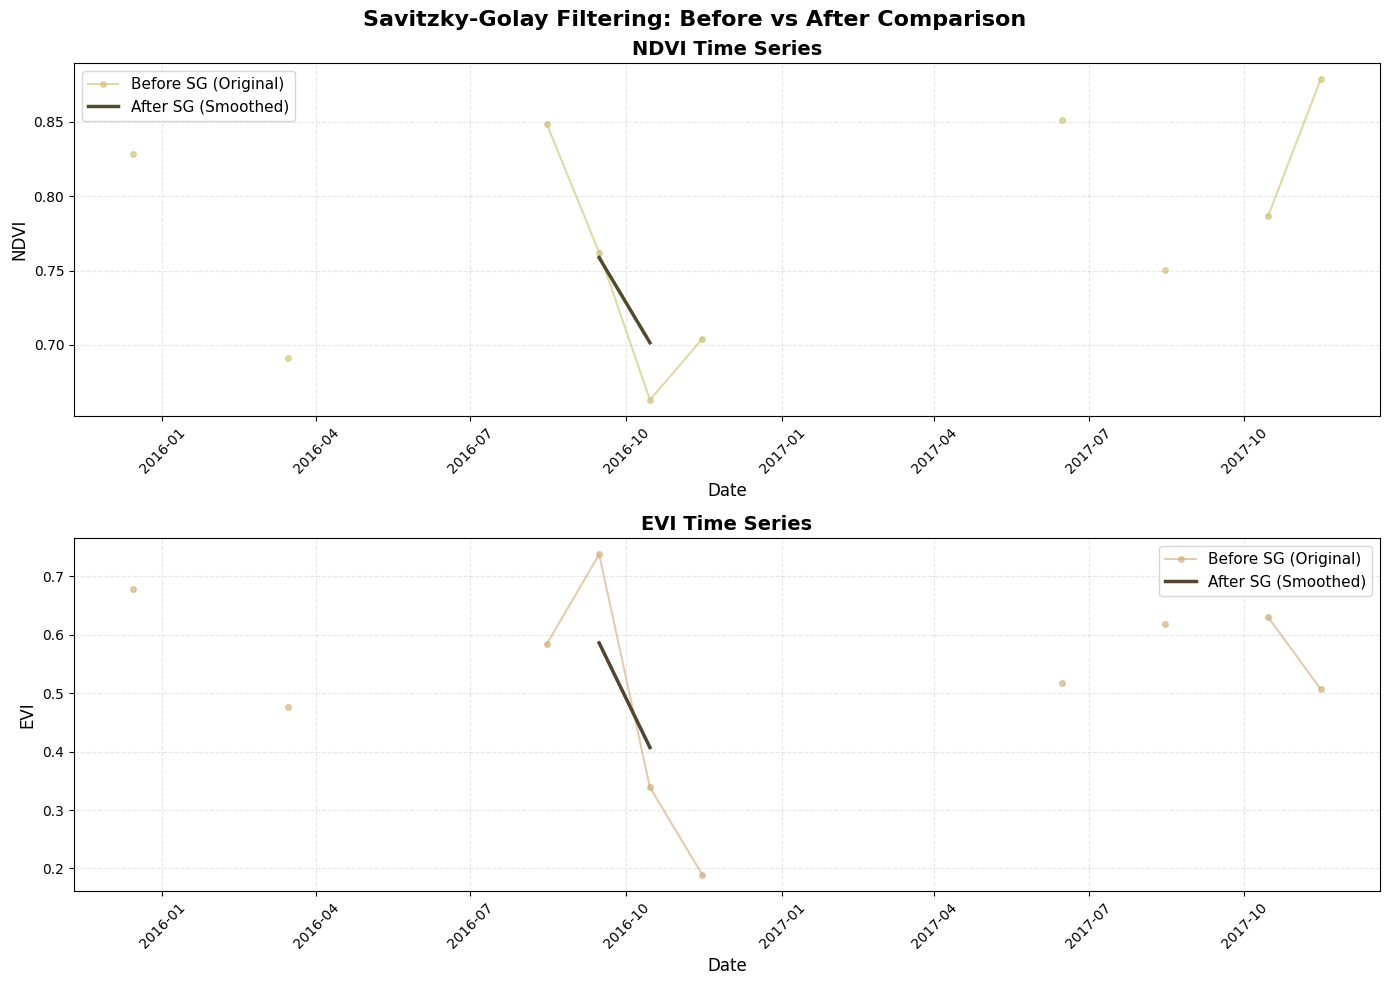


📊 Summary Statistics:

NDVI Statistics:
  Before SG - Mean: 0.7765, Std: 0.0747
  After SG  - Mean: 0.7681, Std: 0.0717
  Noise Reduction: 4.1%

EVI Statistics:
  Before SG - Mean: 0.5278, Std: 0.1642
  After SG  - Mean: 0.5156, Std: 0.0955
  Noise Reduction: 41.8%


In [30]:
# Plot function (exact same as 02b)
import matplotlib.pyplot as plt
import numpy as np

def plot_sg_comparison(ts_before_df, ts_after_df, bands, seed=42):
    """
    Plot before/after Savitzky–Golay time series for a set of bands and print summary stats.
    Exact same function as in notebook 02b.
    """
    bands_to_plot = bands
    n_bands = len(bands_to_plot)

    if n_bands == 0:
        print("⚠️  No bands supplied to plot_sg_comparison!")
        return

    # Generate reproducible color pairs for each band
    np.random.seed(seed)
    colors_info = {}
    for band in bands_to_plot:
        rgb_before = np.random.randint(100, 255, size=3)
        rgb_after = (rgb_before * 0.4).astype(int)
        colors_info[band] = {
            'before': '#{:02x}{:02x}{:02x}'.format(*rgb_before),
            'after': '#{:02x}{:02x}{:02x}'.format(*rgb_after)
        }

    # Print selected color scheme
    print("🎨 Color Scheme for Visualization:")
    print("=" * 60)
    for band, colors in colors_info.items():
        print(f"  {band}:")
        print(f"    Before SG: {colors['before']}")
        print(f"    After SG:  {colors['after']}")
    print()

    # Create figure with one subplot per band
    fig, axes = plt.subplots(n_bands, 1, figsize=(14, 5 * n_bands))
    if n_bands == 1:
        axes = [axes]

    fig.suptitle('Savitzky-Golay Filtering: Before vs After Comparison', fontsize=16, fontweight='bold')

    for ax, band in zip(axes, bands_to_plot):
        if band in ts_before_df.columns and band in ts_after_df.columns:
            color_before = colors_info[band]['before']
            color_after = colors_info[band]['after']

            ax.plot(ts_before_df['date'], ts_before_df[band],
                    'o-', color=color_before, alpha=0.6, linewidth=1.5, markersize=4,
                    label='Before SG (Original)', zorder=1)
            ax.plot(ts_after_df['date'], ts_after_df[band],
                    '-', color=color_after, linewidth=2.5,
                    label='After SG (Smoothed)', zorder=2)

        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(band, fontsize=12)
        ax.set_title(f'{band} Time Series', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=11)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n📊 Summary Statistics:")
    print("=" * 60)
    for band in bands_to_plot:
        if band in ts_before_df.columns and band in ts_after_df.columns:
            before_mean = ts_before_df[band].mean()
            before_std = ts_before_df[band].std()
            after_mean = ts_after_df[band].mean()
            after_std = ts_after_df[band].std()

            print(f"\n{band} Statistics:")
            print(f"  Before SG - Mean: {before_mean:.4f}, Std: {before_std:.4f}")
            print(f"  After SG  - Mean: {after_mean:.4f}, Std: {after_std:.4f}")
            if before_std > 0:
                noise_reduction = (1 - after_std / before_std) * 100
                print(f"  Noise Reduction: {noise_reduction:.1f}%")

# Plot the comparison
# Ensure bands_to_compare is defined (from cell 30)
if 'bands_to_compare' not in locals() and 'bands_to_compare' not in globals():
    # Extract bands from the dataframes (exclude 'date' column)
    bands_to_compare = [col for col in ts_before_df.columns if col != 'date']
    print(f"\n   ⚠️  bands_to_compare not found, extracted from dataframes: {bands_to_compare}")
else:
    print(f"\n   ✅ Using bands_to_compare: {bands_to_compare}")

plot_sg_comparison(ts_before_df, ts_after_df, bands_to_compare)


In [31]:
ts_before_df

,date,NDVI,EVI
0,2015-11-15,NaN,NaN
1,2015-12-15,0.828308,0.678033
2,2016-01-15,NaN,NaN
3,2016-02-15,NaN,NaN
4,2016-03-15,0.691486,0.475992
5,2016-04-15,NaN,NaN
6,2016-05-15,NaN,NaN
7,2016-06-15,NaN,NaN
8,2016-07-15,NaN,NaN
9,2016-08-15,0.848749,0.583679


In [38]:
ts_after_df

,date,NDVI,EVI
0,2015-11-15,NaN,NaN
1,2015-12-15,NaN,NaN
2,2016-01-15,NaN,NaN
3,2016-02-15,NaN,NaN
4,2016-03-15,NaN,NaN
5,2016-04-15,NaN,NaN
6,2016-05-15,NaN,NaN
7,2016-06-15,NaN,NaN
8,2016-07-15,NaN,NaN
9,2016-08-15,NaN,NaN


### Comparison with Notebook 02b

**Notebook 02b approach:**
- Uses GEE ImageCollections (`collection_with_eemont_indices`, `collection_with_sg`)
- Requires `extract_time_series_for_visualization()` that calls GEE's `reduceRegion()` for each collection
- Needs `plot_sg_comparison()` to compare before/after smoothing
- More complex: GEE server-side operations → Python DataFrames → plots
- Slower: Multiple GEE API calls per extraction

**This simplified approach (02g):**
- Converts both collections to xarray first (`ds_before`, `ds_after`)
- Uses native xarray `.isel()` for pixel extraction (much faster)
- Single function `plot_before_after_comparison()` handles everything
- Faster: Direct array operations, no repeated GEE API calls
- Same visualization output: Before vs After comparison plots with statistics

**Key difference:** We convert the "before" collection to xarray once, then extract from both xarray datasets. This is more efficient than calling GEE's `reduceRegion()` multiple times.


In [33]:
# import time
# import ee
# import pandas as pd

# # ---- BEGIN: user / environment variables (adjust if needed) ----
# # These should already be defined in your environment from earlier steps.
# # If not, set them appropriately before running.
# # - list_path_gee_band_gcs : list of GCS/Zarr paths you load with loadZarrV2Array
# # - list_bands              : list of band names (len == 12)
# # - ds_monthly              : xarray dataset with ds_monthly.time and ds_monthly.coords['id']
# # - aoi_ee                  : ee.Feature/ee.Geometry for your AOI
# # - forestry                : your forestry module/config with resolution_satellite, output_crs
# # -----------------------------------------------------------------

# # Example sanity values — remove/comment if you already have these:
# # list_path_gee_band_gcs = [...]     # paths you used earlier
# # list_bands = ["B1","B2", ...]      # 12 names
# # ds_monthly = ...                   # xarray dataset already prepared (25 time steps)
# # aoi_ee = ee.Feature(...)           # your AOI as ee.Feature or ee.Geometry
# # forestry = your_forestry_module    # ensure forestry.initialize_gee() ran

# # ---- Initialize Earth Engine ----
# forestry.initialize_gee()  # uses your forestry wrapper that handles auth and ee.Initialize()
# # or, if you don't need forestry initialization:
# # ee.Initialize()

# # Use given projection (if needed)
# proj = ee.Projection('EPSG:32749')

# # user-provided:
# asset_folder = 'projects/remote-sensing-476412/assets/korindo_sentinel2_monthly_mpc'
# n_bands = 12
# n_images = 25  # from your message
# print(f"\n{'=' * 60}")
# print("EXPORT: Saving processed ImageCollection to GEE asset")
# print(f"{'=' * 60}")
# print(f"   Asset folder: {asset_folder}")
# print("   This may take several minutes...")

# # ---- Load each band as an ImageCollection (server-side objects) ----
# # This replicates your earlier approach but we will convert each collection to a server-side list once.
# list_image_band_gee = [ee.ImageCollection.loadZarrV2Array(path, proj) for path in list_path_gee_band_gcs]

# print(f"📊 Merging {n_bands} bands into one ImageCollection")
# print(f"📅 Number of time steps: {n_images}")

# # ---- Simplify AOI (to reduce geometry complexity that can trigger Error 13) ----
# # Keeps general shape but reduces vertex count. Tweak tolerance if you need higher detail.
# try:
#     aoi_geom = aoi_ee.geometry()
#     # 500 meter simplify tolerance — lower => more vertices. Increase to reduce complexity.
#     aoi_simplified = aoi_geom.simplify(500)
#     region = aoi_simplified
# except Exception as e:
#     # If aoi_ee is already a geometry or in case of error, fallback to original
#     print("Warning: failed to simplify AOI; using original AOI. Error:", e)
#     region = aoi_ee.geometry() if hasattr(aoi_ee, 'geometry') else ee.Geometry(aoi_ee)

# # ---- Convert each ImageCollection to a ee.List once (server-side list of images) ----
# # Doing this once per band is much cheaper than repeated toList() calls inside the inner loop.
# band_image_lists = []
# for idx, band_ic in enumerate(list_image_band_gee):
#     print(f"   Preparing band {idx+1}/{len(list_image_band_gee)} as list ...")
#     # toList with count = n_images (assumes each band collection has at least n_images members in correct order)
#     band_list = ee.ImageCollection(band_ic).toList(n_images)
#     band_image_lists.append(band_list)

# # ---- Get system IDs and timestamps from ds_monthly (Python-side) ----
# system_ids = ds_monthly.coords['id'].values.tolist()
# time_values = ds_monthly.time.values.tolist()  # array-like of datetime64 or strings

# # Safety checks
# if len(system_ids) != n_images:
#     print("Warning: number of system_ids doesn't match n_images (using min length).")
#     n_images = min(n_images, len(system_ids))

# # ---- Build & Export: loop on Python side but use server-side lists to pick images ----
# # This still creates one export task per image, but avoids repeated heavy toList calls.
# for i in range(n_images):
#     print(f"\nPreparing merged image {i+1}/{n_images} ...")
#     try:
#         # Collect band images for this index from each pre-made ee.List
#         band_imgs = [ee.Image(band_list.get(i)) for band_list in band_image_lists]

#         # Merge all bands into a single image (start with first, then addBands)
#         merged_img = ee.Image(band_imgs[0])
#         for bimg in band_imgs[1:]:
#             merged_img = merged_img.addBands(ee.Image(bimg))

#         # Ensure projection/scale (reproject to chosen proj/scale server-side)
#         scale = int(forestry.config.get('resolution_satellite', 10))
#         output_crs = forestry.config.get('output_crs', 'EPSG:32749')

#         merged_img = merged_img.reproject(crs=output_crs, scale=scale)

#         # Set properties (system:id and system:time_start)
#         # Convert python timestamp to millis
#         time_value = time_values[i]
#         ts_millis = int(pd.to_datetime(time_value).timestamp() * 1000)
#         img_id = system_ids[i] if i < len(system_ids) else f"img_{i:04d}"

#         merged_img = merged_img.set({
#             'system:id': img_id,
#             'system:time_start': ts_millis,
#             'bands_list': list_bands  # set band names as metadata (optional)
#         })

#         # Friendly asset id (escape or sanitize img_id if necessary)
#         asset_id = f"{asset_folder}/{img_id}".replace(" ", "_")

#         print(f"   Exporting image {i+1}/{n_images}: {asset_id}")

#         # Start export task (to GEE asset)
#         task = ee.batch.Export.image.toAsset(
#             image=merged_img,
#             description=f"Export_{img_id}",
#             assetId=asset_id,
#             region=region,
#             scale=scale,
#             crs=output_crs,
#             maxPixels=int(1e13)
#         )
#         task.start()

#         print(f"   Task started: {task.id}")

#         # Throttle starts slightly to avoid bursting too many tasks at once.
#         # Adjust sleep seconds if you need slower/faster ramp.
#         time.sleep(1.0)

#     except ee.EEException as e:
#         print("Earth Engine exception while creating/exporting image:", e)
#     except Exception as e:
#         print("Unexpected error:", e)

# print("\n✅ Export tasks started. Open the GEE Code Editor Tasks tab (or https://code.earthengine.google.com/tasks) to monitor progress.")
# print(f"   Once complete, you can use this asset in Part 1 with:\n   asset_folder='{asset_folder}'")
# print(f"📋 Band names: {list_bands}")


In [34]:
# !cd /mnt/data && ls

In [35]:
# forestry.config['resolution_satellite']

In [36]:
# forestry.config
# forestry.config['project_name']

In [37]:
# print(merged_collection)